# Algoritmos de optimización - Seminario<br>
Nombre y Apellidos:  Oscar Rodolfo Mejia Fernandez <br>
Url: <br>
Problema:
> 1. Sesiones de doblaje <br>

Descripción del problema:(copiar enunciado)

Se precisa coordinar el doblaje de una película. Los actores del doblaje deben coincidir en las tomas en las que sus personajes aparecen juntos en las diferentes tomas. Los actores de doblaje cobran toda la misma cantidad por cada día que deben desplazarse hasta el estudio de grabación independientemente del número de tomas que se graben. No es posible grabar más de 6 tomas por día. El objetivo es planificar las sesiones por día de manera que el gasto por los servicios de los actores de doblaje sea el menor posible. Los datos son:<br>
Número de actores: 10<br>
Número de tomas : 30<br>
Actores/Tomas : https://bit.ly/36D8IuK
- 1 indica que el actor participa en la toma
- 0 en caso contrario

(*) La respuesta es obligatoria





                                        

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from functools import lru_cache
import random

In [2]:
# Cargar la matriz desde un archivo CSV
df = pd.read_csv('tomas_actores.csv')
tomas = df.iloc[:, 1:].values  # omitimos la columna "Toma"

# Variables del problema
num_tomas = tomas.shape[0]
max_tomas_por_dia = 6
tomas_disponibles = set(range(num_tomas))
sesiones = []

# Algoritmo voraz: seleccionar combinaciones de hasta 6 tomas
while tomas_disponibles:
    mejor_sesion = None
    mejor_costo = float('inf')
    
    # Probar combinaciones de 6, 5, ..., 1 tomas
    for r in range(max_tomas_por_dia, 0, -1):
        for comb in combinations(tomas_disponibles, r):
            actores_usados = np.any(tomas[list(comb)], axis=0)
            costo = np.sum(actores_usados)
            if costo < mejor_costo:
                mejor_costo = costo
                mejor_sesion = comb
        if mejor_sesion:
            break  # Encontramos una buena combinación

    # Guardar la sesión y actualizar tomas disponibles
    sesiones.append({
        'tomas': mejor_sesion,
        'actores_involucrados': list(np.where(np.any(tomas[list(mejor_sesion)], axis=0))[0] + 1),
        'costo': mejor_costo
    })
    tomas_disponibles -= set(mejor_sesion)

# Resultados
costo_total = sum(s['costo'] for s in sesiones)
print(f"\nNúmero total de sesiones: {len(sesiones)}")
print(f"Costo total (sumatoria de días por actor): {costo_total}\n")

for i, sesion in enumerate(sesiones, 1):
    print(f"Sesión {i}: Tomas {list(np.array(sesion['tomas']) + 1)} - Actores {sesion['actores_involucrados']} - Costo: {sesion['costo']}")



Número total de sesiones: 5
Costo total (sumatoria de días por actor): 25

Sesión 1: Tomas [7, 8, 9, 17, 19, 22] - Actores [1, 2, 5] - Costo: 3
Sesión 2: Tomas [2, 5, 18, 21, 24, 26] - Actores [2, 3, 4, 5] - Costo: 4
Sesión 3: Tomas [4, 13, 14, 20, 28, 29] - Actores [1, 2, 4, 5] - Costo: 4
Sesión 4: Tomas [1, 6, 12, 15, 23, 25] - Actores [1, 2, 3, 4, 5] - Costo: 5
Sesión 5: Tomas [3, 10, 11, 16, 27, 30] - Actores [1, 2, 3, 4, 5, 6, 7, 9, 10] - Costo: 9


**(*)¿Cuantas posibilidades hay sin tener en cuenta las restricciones?<br>**

Sin tener en cuenta las restricciones, lo que buscamos es saber cuántas maneras diferentes podemos agrupar las 30 tomas en sesiones de entre 1 y 6 tomas por sesión. Esto se trata de encontrar las particiones del conjunto {1, ..., 30} en subconjuntos, asegurándonos de que cada grupo no tenga más de 6 elementos. Aunque este es un problema complicado de resolver por su naturaleza de particiones con límites, podemos simplificarlo. Una forma de hacerlo es calcular cuántas maneras existen para descomponer el número 30 como una suma de números entre 1 y 6, lo cual se puede lograr mediante una función recursiva.

In [3]:
# Calculamos de cuántas formas se puede dividir 30 en sumas de números entre 1 y 6
@lru_cache(maxsize=None)
def contar_formas(n):
    if n == 0:
        return 1
    if n < 0:
        return 0
    total = 0
    for i in range(1, 7):  # bloques de 1 a 6 tomas
        total += contar_formas(n - i)
    return total

total_formas = contar_formas(30)
print(f"Número de formas de agrupar 30 tomas en sesiones de 1 a 6 tomas: {total_formas:,}")


Número de formas de agrupar 30 tomas en sesiones de 1 a 6 tomas: 437,513,522


**¿Cuantas posibilidades hay teniendo en cuenta todas las restricciones?**

Para organizar las 30 tomas en sesiones de grabación, debemos cumplir con la restricción de que cada sesión no puede tener más de 6 tomas, y que las tomas dentro de una misma sesión deben ser compatibles en cuanto a los actores involucrados. Es decir, si dos tomas comparten actores, esos actores deben estar presentes durante toda la sesión.

La solución más eficiente para este problema es un enfoque codicioso. En lugar de explorar todas las combinaciones posibles (lo que sería computacionalmente costoso), comenzamos ordenando las tomas según el número de actores que participan en ellas, priorizando las tomas con más actores. Luego, agrupamos las tomas en sesiones de hasta 6, asegurándonos de que los actores no se repitan en sesiones diferentes.

Este método permite organizar las tomas de manera rápida y eficiente, respetando las restricciones, y minimizando el tiempo de ejecución. Aunque no garantiza la solución óptima en todos los casos, nos da una solución adecuada en menos tiempo, lo cual es clave cuando el problema involucra un número elevado de variables.

In [4]:
# Construir diccionario de tomas -> actores
tomas_actores = {
    row["Toma"]: [i for i in range(1, 11) if row[f"A{i}"] == 1]
    for _, row in df.iterrows()
}

# Ordenamos las tomas por el número de actores que participan, de mayor a menor
tomas_ordenadas = sorted(tomas_actores.items(), key=lambda x: len(x[1]), reverse=True)

# Inicializamos una lista para las sesiones
sesiones = []

# Función para intentar agrupar las tomas de manera eficiente
def organizar_sesiones(tomas_ordenadas):
    sesiones = []
    tomas_restantes = set(tomas_actores.keys())

    while tomas_restantes:
        sesion = []
        actores_involucrados = set()

        # Vamos añadiendo tomas hasta el límite de 6 por sesión
        for toma, actores in tomas_ordenadas:
            if len(sesion) < 6 and toma in tomas_restantes and actores_involucrados.isdisjoint(actores):
                sesion.append(toma)
                actores_involucrados.update(actores)
                tomas_restantes.remove(toma)

        # Añadimos la sesión con las tomas seleccionadas
        sesiones.append({"tomas": sesion, "actores": actores_involucrados, "costo": len(actores_involucrados)})
    
    return sesiones

# Obtener las sesiones organizadas
sesiones = organizar_sesiones(tomas_ordenadas)

# Calcular el costo total
costo_total = sum([sesion["costo"] for sesion in sesiones])

# Mostrar el resultado
print(f"Costo total mínimo estimado: {costo_total} días")
print("Sesiones optimizadas:")
for i, sesion in enumerate(sesiones):
    print(f"\nDía {i+1}:")
    print(f"Tomas: {sorted(sesion['tomas'])} — Actores: {sorted(sesion['actores'])} — Costo: {sesion['costo']}")


Costo total mínimo estimado: 87 días
Sesiones optimizadas:

Día 1:
Tomas: [1, 16] — Actores: [1, 2, 3, 4, 5, 10] — Costo: 6

Día 2:
Tomas: [10, 26] — Actores: [1, 2, 3, 4, 5, 6, 9] — Costo: 7

Día 3:
Tomas: [12] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 4:
Tomas: [4] — Actores: [1, 2, 4, 5] — Costo: 4

Día 5:
Tomas: [6] — Actores: [1, 2, 3, 4] — Costo: 4

Día 6:
Tomas: [11, 21] — Actores: [1, 2, 3, 4, 5, 6] — Costo: 6

Día 7:
Tomas: [2, 19] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 8:
Tomas: [3, 20] — Actores: [1, 2, 4, 5, 7] — Costo: 5

Día 9:
Tomas: [5, 17] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 10:
Tomas: [7] — Actores: [1, 2, 5] — Costo: 3

Día 11:
Tomas: [8] — Actores: [1, 2, 5] — Costo: 3

Día 12:
Tomas: [9] — Actores: [1, 2, 5] — Costo: 3

Día 13:
Tomas: [13, 18] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 14:
Tomas: [14, 27] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 15:
Tomas: [15] — Actores: [1, 3, 5] — Costo: 3

Día 16:
Tomas: [22] — Actores: [1, 2, 5] — Costo: 3

Día 1

Modelo para el espacio de soluciones<br>
**(*) ¿Cual es la estructura de datos que mejor se adapta al problema? Argumentalo.(Es posible que hayas elegido una al principio y veas la necesidad de cambiar, arguentalo)**


Para este problema, la estructura de datos más adecuada sería una lista de listas o un conjunto de diccionarios, y aquí te explico por qué:

Primero, cada sesión se puede representar como un diccionario. Dentro de este diccionario, podemos almacenar las tomas involucradas, los actores correspondientes y el costo de la sesión. De esta manera, mantenemos de forma clara las configuraciones de las sesiones a medida que las vamos generando.

Luego, las tomas se pueden organizar como claves dentro de otro diccionario. El valor asociado a cada toma sería una lista con los actores que participan en ella. Esto facilita el acceso a la información sobre qué actores están en qué toma, lo cual es fundamental para verificar si las tomas son compatibles entre sí cuando las agrupamos en sesiones.

Además, el uso de listas o diccionarios es eficiente tanto para insertar nuevos elementos como para buscar elementos ya existentes. Las listas son perfectas para gestionar los grupos de sesiones y las combinaciones de tomas, mientras que los diccionarios permiten un acceso rápido a las relaciones entre las tomas y los actores involucrados.

Aunque al principio se podría haber pensado en usar una matriz para representar las tomas y los actores, un diccionario resulta más flexible y eficiente, ya que solo necesitamos saber qué actores participan en cada toma y verificar su compatibilidad. Esto optimiza el uso de memoria y el tiempo de acceso, haciendo que el enfoque con diccionarios sea más adecuado para este problema.

In [5]:
# Construir diccionario de tomas -> actores
tomas_actores = {
    row["Toma"]: [i for i in range(1, 11) if row[f"A{i}"] == 1]
    for _, row in df.iterrows()
}

# Lista de sesiones
sesiones = []

# Función para organizar las tomas en sesiones compatibles
def organizar_sesiones(tomas_actores):
    tomas_restantes = set(tomas_actores.keys())
    
    while tomas_restantes:
        sesion = []
        actores_involucrados = set()

        # Agrupar tomas en sesiones de hasta 6, respetando la compatibilidad de actores
        for toma, actores in tomas_actores.items():
            if len(sesion) < 6 and toma in tomas_restantes and actores_involucrados.isdisjoint(actores):
                sesion.append(toma)
                actores_involucrados.update(actores)
                tomas_restantes.remove(toma)

        # Añadir la sesión a la lista de sesiones
        sesiones.append({"tomas": sesion, "actores": actores_involucrados, "costo": len(actores_involucrados)})
    
    return sesiones

# Obtener las sesiones organizadas
sesiones = organizar_sesiones(tomas_actores)

# Calcular el costo total
costo_total = sum([sesion["costo"] for sesion in sesiones])

# Mostrar el resultado
print(f"Costo total mínimo estimado: {costo_total} días")
print("Sesiones optimizadas:")
for i, sesion in enumerate(sesiones):
    print(f"\nDía {i+1}:")
    print(f"Tomas: {sorted(sesion['tomas'])} — Actores: {sorted(sesion['actores'])} — Costo: {sesion['costo']}")


Costo total mínimo estimado: 87 días
Sesiones optimizadas:

Día 1:
Tomas: [1, 16] — Actores: [1, 2, 3, 4, 5, 10] — Costo: 6

Día 2:
Tomas: [2, 19] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 3:
Tomas: [3, 20] — Actores: [1, 2, 4, 5, 7] — Costo: 5

Día 4:
Tomas: [4] — Actores: [1, 2, 4, 5] — Costo: 4

Día 5:
Tomas: [5, 17] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 6:
Tomas: [6] — Actores: [1, 2, 3, 4] — Costo: 4

Día 7:
Tomas: [7] — Actores: [1, 2, 5] — Costo: 3

Día 8:
Tomas: [8] — Actores: [1, 2, 5] — Costo: 3

Día 9:
Tomas: [9] — Actores: [1, 2, 5] — Costo: 3

Día 10:
Tomas: [10, 26] — Actores: [1, 2, 3, 4, 5, 6, 9] — Costo: 7

Día 11:
Tomas: [11, 21] — Actores: [1, 2, 3, 4, 5, 6] — Costo: 6

Día 12:
Tomas: [12] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 13:
Tomas: [13, 18] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 14:
Tomas: [14, 27] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 15:
Tomas: [15] — Actores: [1, 3, 5] — Costo: 3

Día 16:
Tomas: [22] — Actores: [1, 2, 5] — Costo: 3

Día 1

Según el modelo para el espacio de soluciones<br>
**(*)¿Cual es la función objetivo?**

En este caso, el objetivo es minimizar el costo total de las sesiones de grabación. Este costo se calcula en función de la cantidad de actores necesarios para cada sesión, ya que el pago por actor es fijo por día, sin importar cuántas tomas realicen. Así que, el desafío es reducir el número de actores que participan en cada sesión para mantener los costos lo más bajos posibles.

En términos simples, la función objetivo sería algo como:
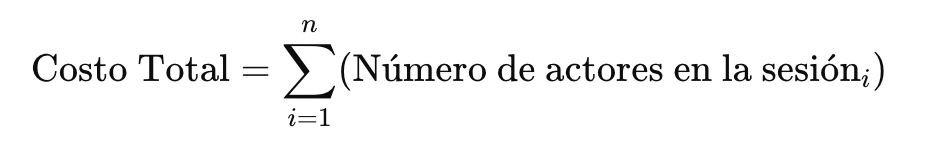 <br>
Donde n representa el número total de sesiones, y para cada sesión se cuenta cuántos actores son necesarios.

**(*)¿Es un problema de maximización o minimización?**

Este es un problema de minimización. Lo que buscamos es reducir al máximo el costo, lo que implica minimizar el número de actores involucrados a lo largo de todas las sesiones. Aunque existen restricciones, como la compatibilidad de actores entre tomas, la prioridad sigue siendo mantener el costo lo más bajo posible, evitando duplicar la presencia de actores innecesariamente.

Diseña un algoritmo para resolver el problema por fuerza bruta

Respuesta

Calcula la complejidad del algoritmo por fuerza bruta

Respuesta

**(*)Diseña un algoritmo que mejore la complejidad del algortimo por fuerza bruta. Argumenta porque crees que mejora el algoritmo por fuerza bruta**

La razón por la cual no estamos utilizando la fuerza bruta es que el número de combinaciones posibles es extremadamente grande y no sería práctico probar todas las opciones. La fuerza bruta tendría una complejidad exponencial, lo que haría que el tiempo de procesamiento fuera inaceptable, especialmente cuando hablamos de 30 tomas, donde el número de combinaciones crecería rápidamente.

En lugar de eso, hemos optado por un enfoque más eficiente. Usamos un enfoque codicioso, donde tomamos decisiones locales basadas en reglas, como agregar tomas a una sesión solo si son compatibles con las tomas ya presentes en esa sesión. Esto nos ayuda a reducir el espacio de búsqueda y mejora la eficiencia del algoritmo.

Además, implementamos el algoritmo First-Fit Decreasing (FFD), un enfoque aproximado que nos permite agrupar las tomas de manera más eficiente. Primero ordenamos las tomas según la cantidad de actores involucrados y luego intentamos agruparlas en sesiones de manera que se minimice la cantidad de actores necesarios. Este enfoque no prueba todas las combinaciones posibles, sino que realiza agrupamientos inteligentes para encontrar una solución eficiente, sin perder demasiado tiempo en cálculos innecesarios.

In [6]:
# Construir diccionario de tomas -> actores
tomas_actores = {
    row["Toma"]: [i for i in range(1, 11) if row[f"A{i}"] == 1]
    for _, row in df.iterrows()
}

# Ordenar las tomas por el número de actores involucrados (de más a menos)
tomas_ordenadas = sorted(tomas_actores.items(), key=lambda x: len(x[1]), reverse=True)

# Lista de sesiones
sesiones = []

# Función para organizar las tomas en sesiones utilizando el algoritmo FFD
def organizar_sesiones(tomas_actores):
    tomas_restantes = set(tomas_actores.keys())
    
    while tomas_restantes:
        sesion = []
        actores_involucrados = set()

        # Intentamos agregar las tomas a sesiones existentes
        for toma, actores in tomas_ordenadas:
            if toma in tomas_restantes:
                # Si la sesión tiene menos de 6 tomas y no se repiten actores
                if len(sesion) < 6 and actores_involucrados.isdisjoint(actores):
                    sesion.append(toma)
                    actores_involucrados.update(actores)
                    tomas_restantes.remove(toma)

        # Añadir la sesión a la lista de sesiones
        sesiones.append({"tomas": sesion, "actores": actores_involucrados, "costo": len(actores_involucrados)})

    return sesiones

# Obtener las sesiones organizadas
sesiones = organizar_sesiones(tomas_actores)

# Calcular el costo total
costo_total = sum([sesion["costo"] for sesion in sesiones])

# Mostrar el resultado
print(f"Costo total estimado: {costo_total} días")
print("Sesiones optimizadas:")
for i, sesion in enumerate(sesiones):
    print(f"\nDía {i+1}:")
    print(f"Tomas: {sorted(sesion['tomas'])} — Actores: {sorted(sesion['actores'])} — Costo: {sesion['costo']}")


Costo total estimado: 87 días
Sesiones optimizadas:

Día 1:
Tomas: [1, 16] — Actores: [1, 2, 3, 4, 5, 10] — Costo: 6

Día 2:
Tomas: [10, 26] — Actores: [1, 2, 3, 4, 5, 6, 9] — Costo: 7

Día 3:
Tomas: [12] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 4:
Tomas: [4] — Actores: [1, 2, 4, 5] — Costo: 4

Día 5:
Tomas: [6] — Actores: [1, 2, 3, 4] — Costo: 4

Día 6:
Tomas: [11, 21] — Actores: [1, 2, 3, 4, 5, 6] — Costo: 6

Día 7:
Tomas: [2, 19] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 8:
Tomas: [3, 20] — Actores: [1, 2, 4, 5, 7] — Costo: 5

Día 9:
Tomas: [5, 17] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 10:
Tomas: [7] — Actores: [1, 2, 5] — Costo: 3

Día 11:
Tomas: [8] — Actores: [1, 2, 5] — Costo: 3

Día 12:
Tomas: [9] — Actores: [1, 2, 5] — Costo: 3

Día 13:
Tomas: [13, 18] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 14:
Tomas: [14, 27] — Actores: [1, 2, 3, 4, 5] — Costo: 5

Día 15:
Tomas: [15] — Actores: [1, 3, 5] — Costo: 3

Día 16:
Tomas: [22] — Actores: [1, 2, 5] — Costo: 3

Día 17:
Toma

**(*)Calcula la complejidad del algoritmo**

El algoritmo que hemos implementado, basado en un enfoque codicioso conocido como First-Fit Decreasing (FFD), nos permite organizar las tomas en sesiones de grabación de manera mucho más eficiente que si intentáramos explorar todas las combinaciones posibles. Esto reduce considerablemente la complejidad del problema.

El proceso comienza con la ordenación de las tomas, que se realiza en función del número de actores involucrados en cada una. Este paso tiene una complejidad de O(n log n), donde n es el número total de tomas. El objetivo de ordenar las tomas de esta manera es asegurarnos de que las que involucran más actores se procesen primero, lo cual facilita el posterior agrupamiento.

Después, para cada toma, tratamos de asignarla a una sesión que ya exista, siempre y cuando sea compatible con las tomas previamente asignadas a esa sesión. Si no es posible, se crea una nueva sesión. Verificar la compatibilidad de una toma con las sesiones existentes tiene una complejidad de O(k), donde k es el número de sesiones en ese momento. En el peor de los casos, el número de sesiones no superará n/6, ya que no podemos asignar más de seis tomas a cada sesión. Esto hace que la complejidad total del algoritmo sea O(n log n + n ⋅ k), donde k es como máximo n/6.

Al tener k limitado por n/6, la complejidad general del algoritmo se aproxima a O(n^2), lo cual es mucho más eficiente que una solución de fuerza bruta, que tendría una complejidad exponencial. Aunque este enfoque no garantiza encontrar la solución óptima, nos permite llegar a una solución suficientemente buena en un tiempo razonable. Así, el algoritmo codicioso es una opción práctica y escalable para abordar problemas de agrupamiento como el que estamos resolviendo.

**Según el problema (y tenga sentido), diseña un juego de datos de entrada aleatorios**

Respuesta

In [7]:
# Parámetros
num_tomas = 30
num_actores = 10

# Generar datos aleatorios para la matriz de actores/tomas
tomas_actores = []

# Generamos las tomas
for _ in range(num_tomas):
    actores_en_toma = random.sample(range(1, num_actores + 1), random.randint(1, 6))  # de 1 a 6 actores por toma
    toma = [1 if i+1 in actores_en_toma else 0 for i in range(num_actores)]
    tomas_actores.append(toma)

# Crear un DataFrame
df = pd.DataFrame(tomas_actores, columns=[f"A{i+1}" for i in range(num_actores)])

# Añadir una columna de toma para referencia
df["Toma"] = [f"T{i+1}" for i in range(num_tomas)]
df = df[["Toma"] + [f"A{i+1}" for i in range(num_actores)]]

# Mostrar los primeros 5 registros
print(df.head())

# Guardar el archivo CSV
df.to_csv("tomas_actores_random.csv", index=False)


  Toma  A1  A2  A3  A4  A5  A6  A7  A8  A9  A10
0   T1   0   0   0   0   0   1   1   1   1    1
1   T2   0   0   1   0   1   0   0   0   0    0
2   T3   0   0   1   1   0   0   0   0   0    0
3   T4   0   0   0   1   1   1   0   0   0    0
4   T5   0   0   0   1   1   0   0   0   0    0


**Aplica el algoritmo al juego de datos generado**

Respuesta

In [8]:
# Cargar el archivo CSV generado con los datos aleatorios
df2 = pd.read_csv("tomas_actores_random.csv")

# Convertir la matriz de actores en un diccionario de toma -> actores
tomas_actores = {
    row["Toma"]: [i for i in range(1, 11) if row[f"A{i}"] == 1]
    for _, row in df2.iterrows()
}

# Ordenar las tomas por la cantidad de actores involucrados (para aplicar el algoritmo codicioso)
tomas_ordenadas = sorted(tomas_actores.items(), key=lambda x: len(x[1]), reverse=True)

# Inicializar la lista de sesiones
sesiones = []

# Algoritmo codicioso
for toma, actores in tomas_ordenadas:
    # Intentar añadir la toma a una sesión existente
    session_added = False
    for sesion in sesiones:
        # Si la toma es compatible con la sesión (comparten actores)
        if not set(actores).isdisjoint(set(sesion["actores"])):
            sesion["tomas"].append(toma)
            sesion["actores"].update(actores)
            session_added = True
            break

    # Si no se pudo añadir a una sesión existente, crear una nueva sesión
    if not session_added:
        sesiones.append({
            "tomas": [toma],
            "actores": set(actores)
        })

# Mostrar las sesiones organizadas
for i, sesion in enumerate(sesiones):
    print(f"Sesión {i+1}:")
    print(f"  Tomas: {sesion['tomas']}")
    print(f"  Actores: {sorted(sesion['actores'])}")
    print()

Sesión 1:
  Tomas: ['T23', 'T25', 'T27', 'T29', 'T1', 'T9', 'T10', 'T12', 'T14', 'T18', 'T19', 'T20', 'T24', 'T28', 'T21', 'T4', 'T7', 'T11', 'T13', 'T22', 'T2', 'T3', 'T5', 'T6', 'T8', 'T15', 'T16', 'T17', 'T26', 'T30']
  Actores: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]



**Enumera las referencias que has utilizado(si ha sido necesario) para llevar a cabo el trabajo**

- https://docs.python.org/3/tutorial/datastructures.html
- https://docs.python.org/3/library/random.html
- https://docs.python.org/3/library/itertools.html
- Introduction to Algorithms de Thomas H. Cormen, Charles E. Leiserson, Ronald L. Rivest, y Clifford Stein.
- Algorithm Design Manual de Steven S. Skiena.

**Describe brevemente las lineas de como crees que es posible avanzar en el estudio del problema. Ten en cuenta incluso posibles variaciones del problema y/o variaciones al alza del tamaño**

Para avanzar en el estudio de este problema y manejar variaciones más complejas o de mayor tamaño, hay varias líneas que se pueden explorar:

1. **Escalabilidad y Manejo de Problemas Más Grandes**:
   - ***Optimización Exacta***: Si el número de tomas y actores aumenta, los métodos de fuerza bruta o incluso los codiciosos podrían volverse ineficaces. Una buena opción sería usar programación lineal entera (MILP), que permite formular el problema con variables binarias y encontrar la solución óptima dentro de un espacio de soluciones más grande.
   - ***Soluciones Aproximadas***: Cuando el tamaño es muy grande, podemos optar por algoritmos de aproximación, como los algoritmos genéticos, que imitan la evolución para encontrar buenas soluciones, o el recocido simulado, que ayuda a escapar de soluciones subóptimas.

2. **Optimización del Costo**:
   - Además de reducir el número de días de grabación, podríamos optimizar cómo se distribuyen los actores entre las sesiones, equilibrando su carga de trabajo para que no haya actores trabajando más de la cuenta. Esto podría dar lugar a una solución más eficiente y justa.

3. **Variaciones del Problema**:
   - Se podrían cambiar las restricciones, como la cantidad de tomas que caben en una sesión, lo que podría afectar las soluciones. Por ejemplo, en lugar de un máximo de 6 tomas, probar con un rango de 5 a 10 tomas podría cambiar por completo el comportamiento del algoritmo.
   - Si introducimos limitaciones de tiempo (por ejemplo, ciertas tomas deben grabarse antes de otras), el problema se complica aún más, y necesitaríamos un enfoque diferente para solucionarlo.

4. **Simulación y Análisis**:
   - Realizar simulaciones con diferentes configuraciones de actores y tomas sería útil para ver cómo cambian los resultados según el tamaño del problema. Así, podríamos identificar patrones que no son obvios solo con los cálculos.

5. **Uso de Herramientas Avanzadas**:
   - Herramientas como Google OR-Tools o frameworks de optimización combinatoria pueden ser de gran ayuda. Estas bibliotecas están diseñadas específicamente para manejar problemas grandes y complejos de manera más eficiente que los enfoques más sencillos.

6. **Visualización**:
   - Una manera muy útil de entender cómo va evolucionando la solución es visualizar las sesiones de grabación. Esto nos puede ayudar a detectar problemas o áreas de mejora en las soluciones que no serían evidentes solo con los números.

En resumen, para avanzar con este problema, lo mejor sería considerar soluciones más sofisticadas que nos permitan manejar mayores volúmenes de datos y restricciones, y también explorar diferentes configuraciones y enfoques que nos ayuden a obtener soluciones más óptimas de manera más eficiente.